In [2]:
using PyPlot;
using LinearAlgebra; 
using CSV;
using StatsBase;
using DelimitedFiles;

In [28]:
function PGD(x0,ftot,gradf,L,niter,prox)
    x= Array(x0)
    funval = ftot(x0)
    for i = 1:niter
        x = Array(prox(x - 1/L*gradf(x)))
        funval = [funval;ftot(x)]
    end
    return (x,funval)
end  

function GDPolyak(x0,f,gradf,fstar,niter,polyak_version)
    x= Array(x0)
    funval = [f(x0)]
    steps = []
    for i = 1:niter
    
        gd = gradf(x)
        gd2 = norm(gd)^2
        
        alpha = (f(x) - fstar)/gd2;
        x = Array(x - polyak_version*alpha*gd);
        
        steps = [steps;polyak_version*alpha]
        funval = [funval;f(x)]
    end
    return (x,funval,steps)
end  

function APG(x0,ftot,gradf,prox,L,mu,niter)
    x = Array(x0)
    y = Array(x0)
    theta = 1

    cond = mu/L
    mus = Inf
    funval = ftot(x0)

    for i = 1:niter
        theta_ = (1+sqrt(1+ 4*theta^2))/2
        if mu > 0
            cond = mu/L
            beta = (1-sqrt(cond))/(1+sqrt(cond))
        else
            beta = (theta-1)/theta_
        end
        theta = theta_
        y_ = prox(x-1/L*gradf(x))
        x = y_ + beta*(y_-y)
        y = Array(y_)
        funval = [funval;ftot(y)]
    end
    return (y,funval)
end
   
#Restart strategy from Roulet and d'Aspremont
function APGRestart(x0,ftot,gradf,prox,L,fstar,niter,gamma)
    x = Array(x0)
    y = Array(x0)
    theta = 1
    eps = ftot(x0)-fstar
    funval = ftot(x0)
    for i = 1:niter
        theta_ = (1+sqrt(1+ 4*theta^2))/2

        beta = (theta-1)/theta_
        theta = theta_
        y_ = prox(x-1/L*gradf(x))
        x = y_ + beta*(y_-y)
        y = Array(y_)
        funval = [funval;ftot(y)]
            
        if ftot(y) - fstar < eps
            eps *= exp(-gamma)
            x = Array(y)
            theta = 1
        end
    end
    return (y,funval)
    
end
   
#Monotone restart strategy from O'Donoghue and Candes 
function APGMono(x0,ftot,gradf,prox,L,niter)
    x = Array(x0)
    y = Array(x0)
    theta = 1
    eps = ftot(x0)
    mus = Inf
    funval = ftot(x0)
    println(cond)
    for i = 1:niter
        theta_ = (1+sqrt(1+ 4*theta^2))/2

        beta = (theta-1)/theta_
        theta = theta_
        y_ = prox(x-1/L*gradf(x))
        x = y_ + beta*(y_-y)
        
        funval = [funval;ftot(y_)]
        if ftot(y_) > ftot(y)
            
            x = Array(y_)
            theta = 1
        end
        y = Array(y_)
    end
    return (y,funval)
    
end


function AccPolyak(x0,f,g,gradf,prox,L,fstar,niter,iscomposite,version)
    x = Array(x0)
    y = Array(x0)
    v = Array(x0)
    funval = [(f(y)+g(y))]
    mu_ = L
    for i = 1:niter
        y_ = prox(x-1/L*gradf(x))
        
        if iscomposite
            y_L = prox(y_-1/L*gradf(y_))
        
            alpha = (f(y_)+g(y_)-fstar)/(-2*L*(g(y_L) - g(y_) + gradf(y_)[:]'*(y_L[:]-y_[:]) + 0.5*L*norm(y_L-y_)^2))
        else
           alpha = (f(y_)+g(y_)-fstar)/norm(gradf(y_))^2 
        end
        if alpha > 0
                if version == 1
                    mu_ = 1/alpha/2
                else
                    mu_ = min(mu_,1/alpha/2)
                end
        end
        cond = mu_/L
        
        beta = (1-sqrt(cond))/(1+sqrt(cond))
        x_ = y_ + beta*(y_-y)
        
        y = Array(y_)

        x = Array(x_)
        
        funval = [funval;(f(y)+g(y))]
        

    end
    return (y,funval)
    
end



function Newton(x0,fun_logit,grad_logit,hess_logit,niter)
    x = Array(x0);
    funval = [fun_logit(x)]
    for i = 1:niter
       x = Array(x-inv(hess_logit(x))*grad_logit(x)*0.01) 
        funval = [funval;fun_logit(x)]
    end
        return (x,funval)
    return 
end




Newton (generic function with 1 method)

In [4]:

Sonar = CSV.read("./sonar_csv.csv")
Sonar = convert(Matrix,Sonar)
y_sonar = Sonar[:,end]
y_sonar = 1*(y_sonar.=="Rock")
y_sonar = 2*y_sonar.-1
Sonar = Sonar[:,1:(end-1)]
Sonar = convert(Matrix{Float64},Sonar)
Sonar = Sonar .- [mean(Sonar[:,i]) for i = 1:size(Sonar,2)]'
Sonar = Sonar ./ [StatsBase.std(Sonar[:,i]) for i = 1:size(Sonar,2)]'

y_sonar = convert(Array{Float64},y_sonar)

Madelon = readdlm("./madelon_train.data")
y_madelon = readdlm("./madelon_train.labels")
y_madelon = y_madelon[:]
Madelon = Madelon .- [mean(Madelon[:,i]) for i = 1:size(Madelon,2)]'
Madelon = Madelon ./ [StatsBase.std(Madelon[:,i]) for i = 1:size(Madelon,2)]'


Musk = readdlm("./clean1.data",',')
y_musk= convert(Array{Float64},Musk[:,end])
Musk =  convert(Array{Float64},Musk[:,3:(end-1)])
Musk = Musk .- [mean(Musk[:,i]) for i = 1:size(Musk,2)]'
Musk = Musk ./ [StatsBase.std(Musk[:,i]) for i = 1:size(Musk,2)]'
y_musk = 2*y_musk.-1


476-element Array{Float64,1}:
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  ⋮  
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0

## Least Squares

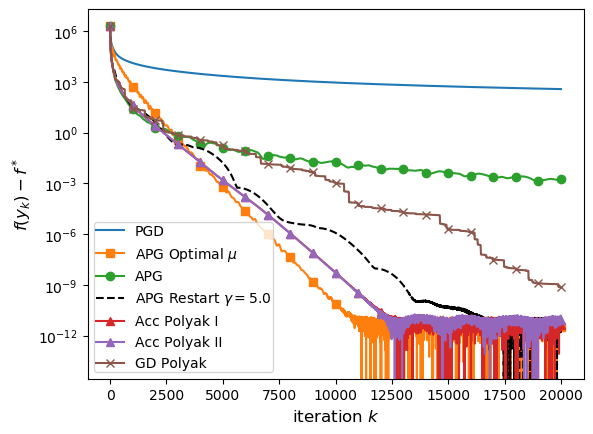

PyObject <matplotlib.legend.Legend object at 0x149e56d50>

In [18]:

#A = Sonar
#y= y_sonar

A = Musk
y= y_musk

(m,n) = size(A)
B = A'*A

L = opnorm(B) 
mu = eigmin(B)

Ay = A'*y

yy= norm(y)^2


function fun_LS(x)    
      return 0.5*(x'*B*x -2*x'*Ay +yy) 
end
function grad_LS(x)
    return B*x- Ay + 0*1.5*0.5*x*norm(x)^(1.5-2)
end

function prox_LS(x::Array{Float64,1})
    return x
end
z(x) =0
x0 = 10(randn(n))
fstar = 0.5*norm(A*inv(B)*Ay - y)^2

max_iter = 20000
(ygd,funvalgd) = PGD(x0,fun_LS,grad_LS,L,max_iter,prox_LS)
(y_apg_mu,funval_apg_mu) = APG(x0,fun_LS,grad_LS,prox_LS,L,mu,max_iter)
(y_apg,funval_apg) = APG(x0,fun_LS,grad_LS,prox_LS,L,0,max_iter)

(y_r,funval_restart) = APGRestart(x0,fun_LS,grad_LS,prox_LS,L,fstar,max_iter,5.5)


iscomposite = false
(y_adapt1,funval_adapt1) = AccPolyak(x0,fun_LS,z,grad_LS,prox_LS,L,fstar,max_iter,iscomposite,1)
(y_adapt2,funval_adapt2) = AccPolyak(x0,fun_LS,z,grad_LS,prox_LS,L,fstar,max_iter,iscomposite,2)


(ygd,funvalgdpl,steps) = GDPolyak(x0,fun_LS,grad_LS,fstar,max_iter,1)

fig = figure()
semilogy((funvalgd.-fstar),marker="None",markevery=500,color="tab:blue",label="PGD")
semilogy(funval_apg_mu.-fstar,marker="s",markevery=1000,color="tab:orange",label=L"APG Optimal $\mu$")
semilogy(funval_apg.-fstar,marker="o",markevery=1000,color="tab:green",label = "APG")
semilogy(funval_restart.-fstar,linestyle="--",markevery=1000,color="black",label=L"APG Restart $\gamma=5.0$")
semilogy(funval_adapt1.-fstar,marker="^",markevery=1000,color="tab:red",label="Acc Polyak I")
semilogy(funval_adapt2.-fstar,marker="^",markevery=1000,color="tab:purple",label="Acc Polyak II")
semilogy([minimum(funvalgdpl[1:i]) for i = 1:length(funvalgdpl)].-fstar,marker="x",markevery=1000,color="tab:brown",label="GD Polyak")

ylabel(L"$f(y_k) - f^*$",fontsize=12)
xlabel(L"iteration $k$",fontsize=12)
#ylim([1e-11;1e9])
#xlim([-200;20000])
legend(borderpad=0.1,fontsize=10)

## Regularized Logistic Regression

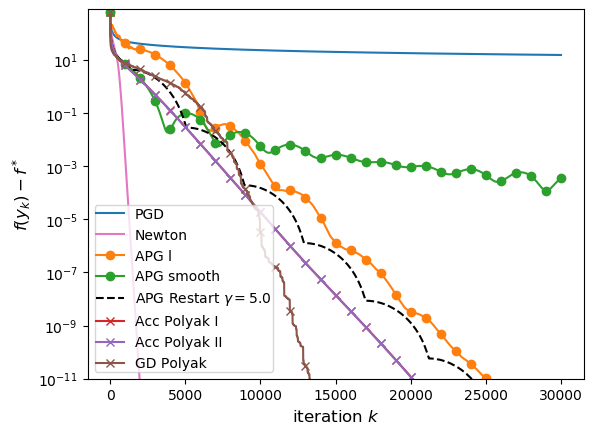

PyObject <matplotlib.legend.Legend object at 0x14b11bf90>

In [26]:
A = Sonar
y = y_sonar

#A = Musk
#y= y_musk

(m,n) = size(A)

lambda_logit = 1e-3

function prox_logit(x::Array{Float64,1})
    return x
end


function fun_logit(x::Array{Float64}) 
    return sum(log.(1 .+ exp.(-y .* (A*x)))) +0.5*lambda_logit*norm(x)^2 
end
function grad_logit(x::Array{Float64}) 
    z=exp.(-y .* (A*x)) 
    return .-sum(A'*Diagonal(y.*(z./(1 .+ z))),dims=2)[:] + lambda_logit*x                  
end

function hess_logit(x::Array{Float64}) 
    z=exp.(-y .* (A*x)) 
    return A'*Diagonal((z./(1 .+ z).^2))*A + lambda_logit*Matrix(I,n,n)                  
end

L = opnorm(A'*A)+lambda_logit
x0 = randn(n)
z(x) = 0


(ynew,fvnew) = Newton(x0,fun_logit,grad_logit,hess_logit,4000)
fstar_log = minimum(fvnew)

max_iter =30000
(ygd,funvalgd) = PGD(x0,fun_logit,grad_logit,L,max_iter,prox_logit)
(y_apg_mu,funval_apg) = APG(x0,fun_logit,grad_logit,prox_logit,L,0,max_iter)
(y_apg_l,funval_apg_l) = APG(x0,fun_logit,grad_logit,prox_logit,L,lambda_logit,max_iter)

iscomposite=false
(y_adapt1,funval_adapt1) = AccPolyak(x0,fun_logit,z,grad_logit,prox_logit,L,fstar_log,max_iter,iscomposite,1)
(y_adapt2,funval_adapt2) = AccPolyak(x0,fun_logit,z,grad_logit,prox_logit,L,fstar_log,max_iter,iscomposite,2)

(y_restart,funval_restart) = APGRestart(x0,fun_logit,grad_logit,prox_logit,L,fstar_log,max_iter,5.0)

(ypdgpl,funvalgdpl,steps_logit) = GDPolyak(x0,fun_logit,grad_logit,fstar_log,max_iter,1)

fig = figure()
semilogy(funvalgd.-fstar_log,marker="None",markevery=500,color="tab:blue",label="PGD")
semilogy(fvnew.-fstar_log,marker="None",markevery=500,color="tab:pink",label="Newton")

semilogy(funval_apg_l.-fstar_log,marker="o",markevery=1000,color="tab:orange",label = "APG l")
semilogy(funval_apg.-fstar_log,marker="o",markevery=1000,color="tab:green",label = "APG smooth")
semilogy(funval_restart.-fstar_log,linestyle="--",markevery=1000,color="black",label=L"APG Restart $\gamma=5.0$")

semilogy(funval_adapt1.-fstar_log,marker="x",markevery=1000,color="tab:red",label="Acc Polyak I")
semilogy(funval_adapt2.-fstar_log,marker="x",markevery=1000,color="tab:purple",label="Acc Polyak II")

semilogy([minimum(funvalgdpl[1:i]) for i=1:length(funvalgdpl)].-fstar_log,marker="x",markevery=1000,color="tab:brown",label="GD Polyak")

ylabel(L"$f(y_k) - f^*$",fontsize=12)
xlabel(L"iteration $k$",fontsize=12)
ylim([1e-11;8e2])
#xlim([-2000;200000])
legend(borderpad=0.1,fontsize=10)

## LASSO

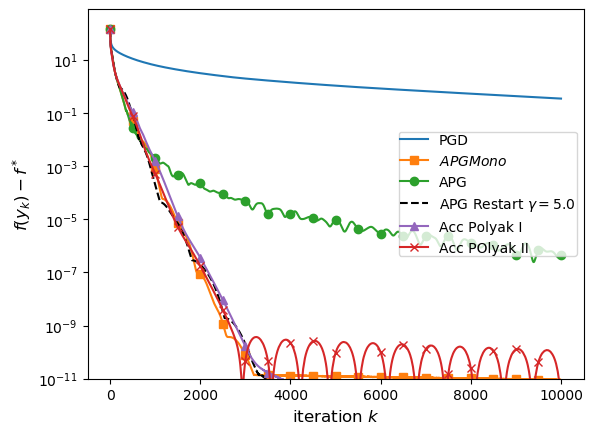

cond


PyObject <matplotlib.legend.Legend object at 0x14e626a50>

In [33]:
#A= Sonar
#y =y_sonar

A = Musk
y= y_musk
(m,n) = size(A)

B = A'*A
L = opnorm(B) 
mu = eigmin(B)
lambda_lasso =1.0
function lasso(x::Array{Float64,1},lambda::Float64)
    return lambda*sum(abs.(x))
end

function prox_lasso(x::Array{Float64,1},lambda::Float64)
    return sign.(x).*max.(abs.(x) .- lambda,0)
end
Ay = A'*y
yy= norm(y)^2

function f_(x::Array{Float64,1}) 
return 0.5*(x'*B*x -2*x'*Ay +yy)
end
function g(x::Array{Float64,1}) 
    return lasso(x,lambda_lasso)
end
function grad_f_lasso(x::Array{Float64,1}) 
    return B*x- Ay
end
function fun_lasso(x::Array{Float64,1}) 
    return f_(x) + g(x)
end

L = opnorm(A'*A)
prox_lasso(x) = prox_lasso(x,lambda_lasso/L)

x0 = zeros(n)


max_iter = 10000

(y_mono,funval_mono) = APGMono(x0,fun_lasso,grad_f_lasso,prox_lasso,L,2*max_iter)
fstar = minimum(funval_mono[.!isnan.(funval_mono)])
(y_r,funval_restart) = APGRestart(x0,fun_lasso,grad_f_lasso,prox_lasso,L,fstar,2*max_iter,5.0)
fstar = minimum(funval_restart[.!isnan.(funval_restart)])
        
(ygd,funvalgd) = PGD(x0,fun_lasso,grad_f_lasso,L,max_iter,prox_lasso)
(y_apg,funval_apg) = APG(x0,fun_lasso,grad_f_lasso,prox_lasso,L,0,max_iter)
(y_r,funval_restart) = APGRestart(x0,fun_lasso,grad_f_lasso,prox_lasso,L,fstar,max_iter,5.0)

iscomposite = true
(y_adapt1,funval_adapt1) = AccPolyak(x0,f_,g,grad_f_lasso,prox_lasso,L,fstar,max_iter,iscomposite,1)
(y_adapt2,funval_adapt2) = AccPolyak(x0,f_,g,grad_f_lasso,prox_lasso,L,fstar,max_iter,iscomposite,2)
fstar = min(fstar,minimum(funval_adapt1[.!isnan.(funval_adapt1)]))
fstar = min(fstar,minimum(funval_adapt2[.!isnan.(funval_adapt2)]))

fig = figure()
semilogy(funvalgd.-fstar,marker="None",markevery=500,color="tab:blue",label="PGD")
semilogy(funval_mono[1:max_iter].-fstar,marker="s",markevery=500,color="tab:orange",label=L"APG Mono")
semilogy(funval_apg.-fstar,marker="o",markevery=500,color="tab:green",label = "APG")
semilogy(funval_restart.-fstar,linestyle="--",markevery=500,color="black",label=L"APG Restart $\gamma=5.0$")
semilogy(funval_adapt1.-fstar,marker="^",markevery=500,color="tab:purple",label="Acc Polyak I")
semilogy(funval_adapt2.-fstar,marker="x",markevery=500,color="tab:red",label="Acc Polyak II")

ylabel(L"$f(y_k) - f^*$",fontsize=12)
xlabel(L"iteration $k$",fontsize=12)
ylim([1e-11;8e2])
#xlim([-2000;200000])
legend(borderpad=0.1,fontsize=10)

## Dual SVM

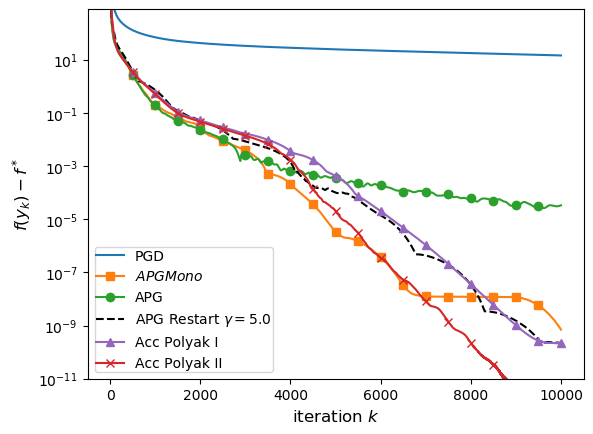

cond


PyObject <matplotlib.legend.Legend object at 0x153907f90>

In [50]:
# A = Sonar
# y = y_sonar
A = Musk
y = y_musk
(m,n) = size(A)
 

B = A'*A 
mu = eigmin(B)
lambda_svm =1.0
Ay = A'*Diagonal(y)
AAy = Ay'*Ay

function svm(x::Array{Float64,1}) 
    return 0.5*(x'*AAy*x) - sum(x)
end
function grad_smooth_svm(x::Array{Float64,1}) 
    return AAy*x.-1
end
function prox_box(x::Array{Float64,1}) 
    return min.(1/lambda_svm,max.(0,x))
end

L = opnorm(AAy)

x0 = randn(m)



z(x) = 0


max_iter = 10000

(y_mono,funval_mono) = APGMono(x0,svm,grad_smooth_svm,prox_box,L,2*max_iter)
fstar = minimum(funval_mono[.!isnan.(funval_mono)])
(y_r,funval_restart_) = APGRestart(x0,svm,grad_smooth_svm,prox_box,L,fstar,2*max_iter,5.0)
fstar = minimum(funval_restart_[.!isnan.(funval_restart_)])

(ygd,funvalgd) = PGD(x0,svm,grad_smooth_svm,L,max_iter,prox_box)

(y_r,funval_restart) = APGRestart(x0,svm,grad_smooth_svm,prox_box,L,fstar,max_iter,5.0)

iscomposite = true
(y_adapt1,funval_adapt1) = AccPolyak(x0,svm,z,grad_smooth_svm,prox_box,L,fstar,max_iter,iscomposite,1)
(y_adapt2,funval_adapt2) = AccPolyak(x0,svm,z,grad_smooth_svm,prox_box,L,fstar,max_iter,iscomposite,2)
fstar = min(fstar,minimum(funval_adapt1[.!isnan.(funval_adapt1)]))
fstar = min(fstar,minimum(funval_adapt2[.!isnan.(funval_adapt2)]))

fig = figure()
semilogy(funvalgd.-fstar,marker="None",markevery=500,color="tab:blue",label="PGD")
semilogy(funval_mono[1:max_iter].-fstar,marker="s",markevery=500,color="tab:orange",label=L"APG Mono")
semilogy(funval_apg[1:max_iter].-fstar,marker="o",markevery=500,color="tab:green",label = "APG")
semilogy(funval_restart.-fstar,linestyle="--",markevery=500,color="black",label=L"APG Restart $\gamma=5.0$")
semilogy(funval_adapt1.-fstar,marker="^",markevery=500,color="tab:purple",label="Acc Polyak I")
semilogy(funval_adapt2.-fstar,marker="x",markevery=500,color="tab:red",label="Acc Polyak II")

ylabel(L"$f(y_k) - f^*$",fontsize=12)
xlabel(L"iteration $k$",fontsize=12)
ylim([1e-11;8e2])
#xlim([-2000;200000])
legend(borderpad=0.1,fontsize=10)

In [45]:
norm((y_adapt2-prox_box(y_adapt2 - 1/L*grad_smooth_svm(y_adapt2)))*L)^2

3.9636426030819196e-15